# Unsupervised Learning Methods
## Outline 
#### 1. Text similarity: cosine similarity, summary extraction
#### 2. Text clusttering: K-mean, visualization with PCA, t-SNE, MDS
#### 3. Build Recommender System

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import plotly.express as px

from scipy.stats import entropy
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS

import re
import string

In [2]:
# download and create the stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english')) | set(stopwords.words('french')) | set(stopwords.words('italian')) | set(stopwords.words('german')) | set(stopwords.words('portuguese')) | set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ymsc1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# get reviews and perform text vectorization

def get_reviews_vectorized(top_n=-1, ngram_range=(1, 1), max_features=1000):
    df = pd.read_pickle("asset/reviews20221010.pkl")
    df = df.dropna()
    df = df.groupby(['wine ID', 'year']).agg({
        'Review': lambda x : ' '.join(x),
        'name':'unique',
        'country':'unique', 
        'winery': 'unique',
        'price': 'unique',
        'rating': 'unique'
        })
    df.reset_index(inplace=True)
    df = df.astype("string")
    df[['price','rating']] = df[['price','rating']].apply(lambda x: x.str[1:-1])
    df[['name', 'country', 'winery']] = df[['name', 'country', 'winery']].apply(lambda x: x.str[2:-2])
    review_instances = df.Review.replace('\d+'," ", regex=True)
    review_instances = review_instances.replace(r'\n',' ', regex=True)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=max_features,
        min_df=10,
        stop_words=stopwords_list,
        ngram_range=ngram_range,
        use_idf=True,
    )
    if top_n >= 0:
        review_instances = review_instances.values[0:top_n]
        df = df[0:top_n]
    else:
        review_instances = review_instances.values


    X = vectorizer.fit_transform(review_instances)

    return (X, vectorizer, review_instances, df)

In [4]:
(X, vectorizer, review_instances, df) = get_reviews_vectorized(-1, (1, 2))

## 1. Text similarity

In [5]:
cosine_similarities = linear_kernel(X, X)

In [6]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []
    
    # Find the index of the input
    idx = indices[indices == name].index[0]
    
    # Find the wines with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])
    
    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])
    
    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))
    
    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new



def sample():
    select = df.sample(n=1)
    name = select['name'].item()
    print('Select %s ' % name)
    
    return select



def make_wordcloud(text):
    # Generate a word cloud image
    text = text
    wordcloud = WordCloud().generate(text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [7]:
select = sample()
select

Select Symphonie Côtes de Provence Rosé 2020 


,wine ID,year,Review,name,country,winery,price,rating
1591,1563499,2020,"Very nice. L-M body with a round mouthfeel, d...",Symphonie Côtes de Provence Rosé 2020,France,Château Sainte Marguerite,39.40403842,4.2


In [8]:
select_name = select.name.item()
recomendation = recommend(select_name)
recomendation

Top 10 wines like Symphonie Côtes de Provence Rosé 2020 with similar reviews: 


,country,winery,price,rating,wine ID,year,Review
Bandol Rosé 2019,France,Domaine Tempier,41.58710576,4.3,83195,2019,Oh the jubilation of sitting outside on a beau...
Symphonie Côtes de Provence Rosé 2020,France,Château Sainte Marguerite,39.40403842,4.2,1563499,2020,"Very nice. L-M body with a round mouthfeel, d..."
Rock Angel Rosé 2019,France,Château d'Esclans,24.70103901,4.2,4522810,2019,"Another try of this marvelous cult wine, 1y la..."
Rosé et Or 2021,France,Minuty,23.03469908,4.2,1193781,2021,"New vintage to try of this stunning classic, e..."
Whispering Angel Rosé 2020,France,Château d'Esclans,18.86884925,4.2,1104824,2020,Another d’Esclans to try out: their most popul...
Château de Selle Rosé (Coeur de Grain) 2021,France,Domaines Ott,26.85747893,4.2,1216610,2021,All hail The Great Ott! 10th anniversary of ou...
Le Pas du Moine Sainte Victoire 2020,France,Château Gassier,31.35510359,4.2,2590250,2020,Bouquet of flowers with this rose from Provenc...
11 Minutes Rosato 2020,Italy,Pasqua Vigneti e Cantine,17.58445401,4.2,5470821,2020,"Great rose, very pale pink-orange color! straw..."
Château Romassan Rosé (Coeur de Grain) 2020,France,Domaines Ott,26.41638894,4.2,1231210,2020,La vie en rosé by @[1|5755096|Christian Ruyffe...
Alìe Rosé Toscana 2021,Italy,Tenuta Ammiraglia,24.95610285,4.1,3941411,2021,Delicious bouquet of strawberries and raspberr...


This is the wordcloud of the select wine looks like...


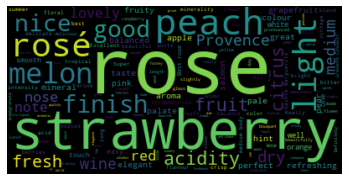

This is the wordcloud of the recommendation list looks like...


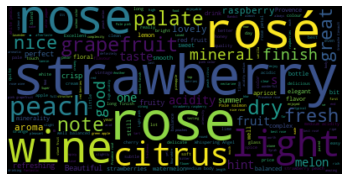

In [9]:
recomendation_review = ' '.join(recomendation.Review.tolist())
select_review = select.Review.item()
print('This is the wordcloud of the select wine looks like...')
make_wordcloud(select_review)
print('This is the wordcloud of the recommendation list looks like...')
make_wordcloud(recomendation_review)

## 2. Text clusttering

#### Firstly, try k-means by two categories.

In [10]:
def kmeans_review_k_2():
    result = None
   
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    features = vectorizer.get_feature_names()    
    sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]    
    top10_clust1 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[0]][:10]
    top10_clust2 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[1]][:10]
    result = [top10_clust1, top10_clust2]

    return result


kmeans_review_k_2()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[['bordeaux',
  'merlot',
  'cassis',
  'blackcurrant',
  'syrah',
  'cabernet',
  'malbec',
  'cab',
  'black currant',
  'shiraz'],
 ['lemon',
  'pear',
  'peach',
  'champagne',
  'bubbles',
  'green apple',
  'honey',
  'yellow',
  'grapefruit',
  'chardonnay']]

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



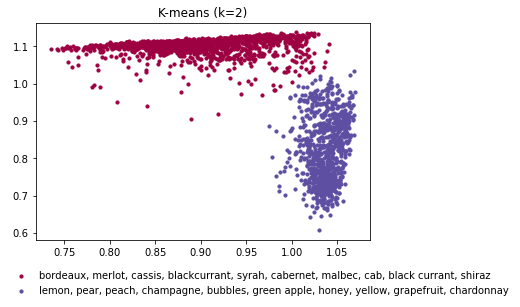

In [90]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
def scatter_plot():
    colors = cm.Spectral(np.linspace(0, 1, 2))
    cdict = {0: colors[0], 1: colors[1]}
    
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    X_km = km.transform(X_ar)
    y = km.fit_predict(X_ar)
    label1 = ', '.join(kmeans_review_k_2()[0])
    label2 = ', '.join(kmeans_review_k_2()[1])

    fig, ax = plt.subplots()
    for cls in np.unique(y):
        ix = np.where(y == cls)
        ax.scatter(X_km[ix, 0], X_km[ix, 1], color = cdict[cls], label = cls, s = 10)
    ax.legend((label1, label2), bbox_to_anchor=(-0.1, -0.1), loc='upper left', frameon=False)
    ax.set_title('K-means (k=2)')
    plt.show()


scatter_plot()

In [76]:
', '.join(kmeans_review_k_2()[0])

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



'bordeaux, merlot, cassis, blackcurrant, syrah, cabernet, malbec, cab, black currant, shiraz'

In [12]:
def km_2_by_plotly(X, title):
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    X_km = km.transform(X_ar)
    y = km.fit_predict(X_ar)

    labels = [', '.join(wd) for wd in np.array(kmeans_review_k_2())[y]] 
    df_km = pd.DataFrame(X_km, columns=['x', 'y'])
    df_km['labels'] = labels
    df_plot = pd.concat([df_km, df], axis=1)


    fig = px.scatter(
    df_plot, x='x', y='y',
    color='labels', title=title, 
    hover_data=['name', 'country', 'winery', 'price', 'rating']
    )
    fig.write_html("plotly/%s.html" % title)
    fig.show()

km_2_by_plotly(X, 'K-means')

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Interesting! It seems the k-means finds two discrete categories, the "red" and the "white"! There are more categories for wines! <br>We want to explore the optimal number of clusters using the elbow method. 

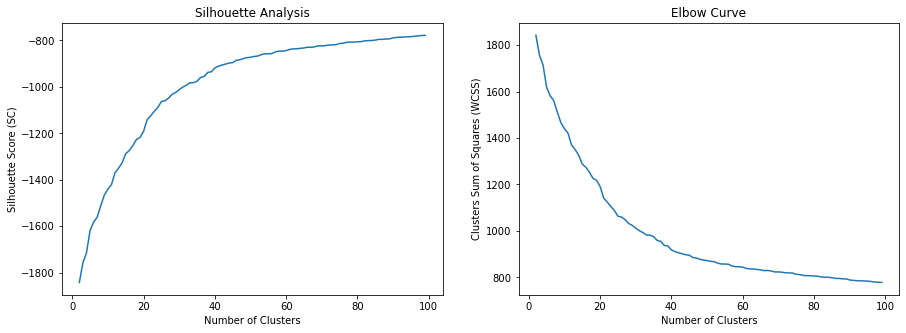

In [13]:
# elbow curve for exploring k values for KNN
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
X_ar = X.toarray()
Nc = range(2, 100)

kmeans = [KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, random_state=42) for i in Nc]
sc = [kmeans[i].fit(X_ar).score(X_ar) for i in range(len(kmeans))]
wcss = [kmeans[i].fit(X_ar).inertia_ for i in range(len(kmeans))]



axes[0].plot(Nc,sc)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score (SC)')
axes[0].set_title('Silhouette Analysis')

axes[1].plot(Nc,wcss)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Clusters Sum of Squares (WCSS)')
axes[1].set_title('Elbow Curve')


plt.show()

#### The optimal number of clustters is near 30. We set k=30 for the K-means. <br>Next, we want create labels for each cluster by extracting discrete words in the reviews of each wine.

In [14]:
def compute_distinctive_term_score(T, T_a):
    # First compute information gain.
    IG = entropy(T) - entropy(T_a)

    # if it's high IG, but not for this class, we want to penalize,
    # so flip the IG negative.  We do this because these are terms those whose *absence* is notable,
    # but we don't care about those for purposes of this assignment and so we give them
    # a score that guarantees we won't rank them highly.
    if T_a[0] < T_a[1]:
        score = -IG
    else:
        score = IG
    return score


# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index + 1 :, :])).sum(axis=0)

    result = np.vstack((row0, row1))
    return result

In [15]:
def answer_cluster_labeling(n_clusters=7):
    result = None

    X_ar = X.toarray()
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    ig = np.empty([n_clusters, 1000])
    for c in range(n_clusters):
        tc = one_vs_all_count_matrix(centroids, c).sum(axis=1)/one_vs_all_count_matrix(centroids, c).sum(axis=1).sum(axis=0)
        for w in range(1000):
            tw = one_vs_all_count_matrix(centroids, c)[:,w]/one_vs_all_count_matrix(centroids, c).sum(axis=0)[w]
            ig[c,w] = compute_distinctive_term_score(tc, tw)
    features = vectorizer.get_feature_names()    
    sorted_ig_idx = ig.argsort(axis=1)[:,::-1] 
    result = []
    for c in range(n_clusters):
        result.append([features[feature_idx] for feature_idx in sorted_ig_idx[c]][:5])
    return result


answer_cluster_labeling(30)

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



[['blanc', 'quince', 'grenache', 'rhone', 'peach pear'],
 ['chocolate oak',
  'italian',
  'cherry chocolate',
  'italy',
  'chocolate vanilla'],
 ['mousse', 'fine bubbles', 'brut', 'biscuit', 'yeasty'],
 ['eucalyptus', 'drop', 'chocolate oak', 'plum blackberry', 'mocha'],
 ['bordeaux', 'second wine', 'petit verdot', 'verdot', 'bordeaux blend'],
 ['tempranillo',
  'spanish',
  'vanilla leather',
  'leather vanilla',
  'vanilla tobacco'],
 ['rhône', 'rhone', 'olive', 'olives', 'deep purple'],
 ['natural',
  'cru',
  'strawberry cherry',
  'pomegranate',
  'raspberry strawberry'],
 ['saline', 'pear lemon', 'white wine', 'pear apple', 'salt'],
 ['verdot', 'petit verdot', 'inky', 'bordeaux blend', 'final'],
 ['cab franc', 'franc', 'cabernet franc', 'cabernet', 'cf'],
 ['bubbly', 'brut', 'fine bubbles', 'bubbles', 'mousse'],
 ['burgundy',
  'strawberry cherry',
  'raspberry strawberry',
  'raspberry cherry',
  'forest floor'],
 ['rose', 'pink', 'salmon', 'strawberries', 'strawberry raspberr

In [16]:
def answer_manifold_a():
    result = None

    # YOUR CODE HERE
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)

    pca = PCA(n_components=2, random_state = 42)
    X_pca = pca.fit_transform(X_ar)
    
    tsne = TSNE(n_components=2, random_state = 42)
    X_tsne = tsne.fit_transform(X_ar)
    
    mds = MDS(n_components=2, random_state = 42)
    X_mds = mds.fit_transform(X_ar)

    result = (X_pca, X_tsne, X_mds)
    return result

X_pca, X_tsne, X_mds = answer_manifold_a()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



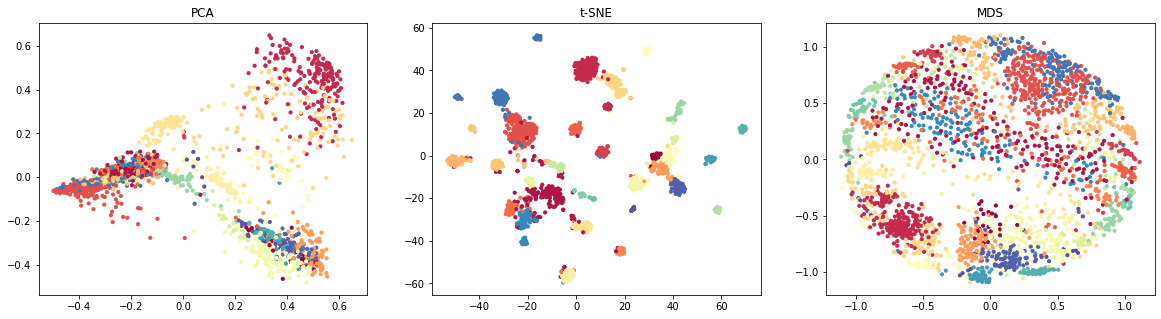

In [17]:
def plot_manifolds():
    colors = cm.Spectral(np.linspace(0, 1, 30))
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[y])
    axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, color=colors[y])
    axes[2].scatter(X_mds[:, 0], X_mds[:, 1], s=10, color=colors[y])

    axes[0].set_title("PCA")
    axes[1].set_title("t-SNE")
    axes[2].set_title("MDS")
    plt.show()

plot_manifolds()

#### Same visualizations build on Plotly. Enjoy the interactive experiences!

In [18]:
def scatterplot_by_plotly(X, manifolds, title):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_manifolds = pd.DataFrame(manifolds, columns=['x', 'y'])
    df_manifolds['labels'] = labels
    df_plot = pd.concat([df_manifolds, df], axis=1)


    fig = px.scatter(
    df_plot, x='x', y='y',
    color='labels', title=title, 
    hover_data=['name', 'country', 'winery', 'price', 'rating']
    )
    fig.write_html("plotly/%s.html" % title)
    fig.show()

In [19]:
scatterplot_by_plotly(X, X_pca, "PCA")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [20]:
scatterplot_by_plotly(X, X_tsne, "t-SNE")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [21]:
scatterplot_by_plotly(X, X_mds, "MDS")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



## 3. Build Recommender System

In [22]:
def recommend_knn(name):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_knn = df.copy()
    df_knn['labels'] = labels

    select_label = df_knn[df_knn.name == name].sample(n=1)['labels']
    df_new = df_knn[df_knn.labels == select_label]
    
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new

In [23]:
def get_mean_vector(wine_list):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)
    vectors = []
    
    for wine in wine_list:
        idx = indices[indices == wine].index[0]
        vector = km.transform(X_ar[idx].reshape(1, -1))
        vectors.append(vector)  
    
    song_matrix = np.array(list(vectors))
    return np.mean(song_matrix, axis=0)




def recommend_knn(wine_list):
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)

    # Find the wines with a similar cosine-sim value and order them from bigges number
    wine_center = get_mean_vector(wine_list).reshape(1, -1)
    wine_data = km.transform(X_ar)

    distances = cdist(wine_center, wine_data, 'cosine')

    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(np.argsort(distances)[:, :30][0])


    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])

    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])

    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))

    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)

    print('Top wines with similar reviews according to the user list: ')

    return df_new




def sample_list(n=5):
    select = df.sample(n)
    for i in range(n):
        name = select.name.iloc[i]
        print('Select %s ' % name)
    
    return select

In [24]:
user_sample = sample_list(5)
user_list = user_sample.name.tolist()
user_sample

Select Beso de Dante 2017 
Select Coma Vella Priorat 2014 
Select Vinsanto del Chianti Classico 2015 
Select Bordeaux 2014 
Select La Capilla Estate Cabernet Sauvignon 2012 


,wine ID,year,Review,name,country,winery,price,rating
369,74337,2017,"Good wine, great value. Notes of leather, plum...",Beso de Dante 2017,Argentina,Luca,41.38452442,4.4
1232,1207249,2014,Drinking them up in the cellar since they are ...,Coma Vella Priorat 2014,Spain,Mas d'en Gil,35.28719859,4.2
1239,1208032,2015,Very nice. Not too sweet. Raisins chestnut. I’...,Vinsanto del Chianti Classico 2015,Italy,Antinori,43.48120997,4.3
1826,2001637,2014,"Subtle, seductive aroma of stone fruit, berrie...",Bordeaux 2014,France,Neipperg Collection,13.72279945,3.7
990,1164612,2012,Another excellent single vineyard wine from Vi...,La Capilla Estate Cabernet Sauvignon 2012,Chile,Viu Manent,22.93667908,3.8


In [25]:
recomendation_list = recommend_knn(user_list)
recomendation_list

Top wines with similar reviews according to the user list: 


,country,winery,price,rating,wine ID,year,Review
Initial de Desmirail Margaux 2016,France,Château Desmirail,45.0891982,4.3,23751,2016,plum blackberry leather coffee oak pepper Eno...
Pomerol 2015,France,Château La Grave (Trigant de Boisset),44.05998824,4.3,1614239,2015,"Muted at first, after airing for a while it re..."
Pomerol 2015,France,Le Clos du Beau-Père,47.93177808,4.3,1189749,2015,"Great Pomerol red, astonishing nose of blueber..."
Mea Culpa Rosso N.V.,Italy,Cantine Minini,14.99,4.2,5594845,N.V.,"Dark red almost black, strong in the glass. Sm..."
Pomerol 2015,France,Clos Rene,38.22779847,4.2,1146003,2015,"blend of 70% Merlot, 20% Cabernet Franc and 10..."
Leggero Appassimento Puglia 2019,Italy,Bastioni della Rocca,13.43150254,4.1,9335092,2019,Smooth chocolate and oak on the palate with ju...
Pomerol 2015,France,Château Beau Soleil,38.38760539,4.1,1191619,2015,"Pepper and earthy. Very good Pomerol, one of ..."
Loma Blanca Single Vineyard Carménère 2018,Chile,Viu Manent,24.70103901,4.1,7750599,2018,Deep purple carmenere with blackberry and oaky...
Coeur de Cuvée Bordeaux Supérieur 2016,France,Château Lagrave Paran,29.43540337,4.1,7019644,2016,Can drink now. Complex smokiness makes this h...
Fra'Passo Primitivo di Manduria 2019,Italy,Piccini,17.58445401,4.1,9148180,2019,"Garnet with a brown haze. Sour red cherry 🍒, ..."


This is the wordcloud of the user list looks like...


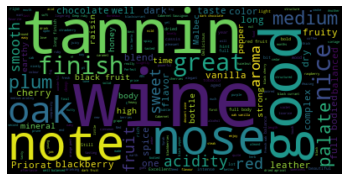

This is the wordcloud of the recommendation list looks like...


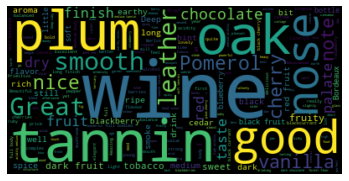

In [26]:
user_sample_1_review = ' '.join(user_sample.Review.tolist())
print('This is the wordcloud of the user list looks like...')
make_wordcloud(user_sample_1_review)
recomendation_list_review = ' '.join(recomendation_list.Review.tolist())
print('This is the wordcloud of the recommendation list looks like...')
make_wordcloud(recomendation_list_review)